In [2]:
import sys
import os

# Obtener la ruta al directorio padre
root = os.path.abspath(r'..\..')

# Agregar la ruta al sys.path para que Python busque en el directorio padre
sys.path.append(root)

import h5py as h5
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow import keras
from modules.loaders import LoadDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
###* Load the dataset
dataset = LoadDataset('positions_dynamics.h5').load_h5()
type(dataset)

h5py._hl.files.File

In [4]:
with dataset as h5file:
    data_h5 = []
    labels = []
    for letter in h5file.keys():
        positions = h5file[letter]['positions'][:]
        data_h5.append(positions)
        # print(positions.shape)
        labels.extend([letter]*positions.shape[0]) # extend is used to add the elements of the list, not the list itself  

labels = np.array(labels)
labels_letter = np.reshape(labels, (labels.shape[0], ))
labels_letter.shape


(2002,)

In [5]:
labels_letter

array(['23', '23', '23', ..., 'YO', 'YO', 'YO'], dtype='<U12')

In [6]:
for i, id in enumerate(data_h5):
    print('Data shape',i, id.shape)

Data shape 0 (200, 30, 84)
Data shape 1 (200, 30, 84)
Data shape 2 (199, 30, 84)
Data shape 3 (200, 30, 84)
Data shape 4 (200, 30, 84)
Data shape 5 (200, 30, 84)
Data shape 6 (200, 30, 84)
Data shape 7 (200, 30, 84)
Data shape 8 (201, 30, 84)
Data shape 9 (202, 30, 84)


#### Remember   m -> number of samples, Tx -> frames,  features -> 21*4 (positions in x and y)  

In [7]:
label_encoder = LabelEncoder() ###* LETTERS TO NUMBERS 
labels = label_encoder.fit_transform(labels_letter)
print('The number of classes is:', len(label_encoder.classes_))
labels.shape

The number of classes is: 10


(2002,)

In [8]:
labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [9]:
label_encoder.classes_

array(['23', 'BUENO', 'HOLA', 'MAL', 'NO', 'NOMBRE', 'QUETALL', 'SI',
       'VEINTICUATRO', 'YO'], dtype='<U12')

### For every sample m we have one label

In [10]:
data = np.concatenate(data_h5,axis=0)
data.shape

(2002, 30, 84)

#### sklearn needs data.shape = (m, Tx, nx), where:
#### m is the number of samples
#### Tx is the number of sequences (frames in this case)
#### nx number of featues (positions in this case)

In [11]:
X_train, X, y_train, Y = train_test_split(data, labels, test_size=0.4)

In [12]:
X_train.shape, y_train.shape, X.shape, Y.shape

((1201, 30, 84), (1201,), (801, 30, 84), (801,))

In [13]:
y_train

array([0, 2, 1, ..., 7, 6, 3], dtype=int64)

#### Now we have our train dataset but we need a dev and test dataset

In [14]:
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.5, )

In [15]:
m = X_train.shape[0] # number of samples
print(f'Traininig set: {X_train.shape[0]} samples')
print(f'Dev set: {X_dev.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Traininig set: 1201 samples
Dev set: 400 samples
Test set: 401 samples


##### We have 60% for training and 40% for dev,test data
##### Now we need to normalize the data, let's to use the z-score method

In [16]:
# # Crear el escalador y ajustar a los datos de entrenamiento
# from sklearn.preprocessing import MinMaxScaler
# # Reestructurar para agrupar todas las muestras y timesteps
# X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (m*t, features)
# X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
# X_dev_reshaped = X_dev.reshape(-1, X_dev.shape[-1])

# # Crear y ajustar el escalador con los datos de entrenamiento
# scaler = MinMaxScaler()
# X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)

# # Transformar los datos de prueba y validación con el mismo escalador
# X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
# X_dev_scaled_reshaped = scaler.transform(X_dev_reshaped)

# # Restaurar la forma original
# X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
# X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)
# X_dev_scaled = X_dev_scaled_reshaped.reshape(X_dev.shape)

# # Imprimir formas como verificación
# print("X_train escalado:", X_train_scaled.shape)
# print("X_test escalado:", X_test_scaled.shape)
# print("X_dev escalado:", X_dev_scaled.shape)


### ONE HOT to create our matrix with labels

In [17]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_dev_onehot = encoder.transform(y_dev.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
y_train_onehot.shape, y_dev_onehot.shape, y_test_onehot.shape

((1201, 10), (400, 10), (401, 10))

In [18]:
y_train_onehot.shape

(1201, 10)

In [19]:
# Convertir el array a una serie de pandas
import pandas as pd
y_dev_series = pd.Series(y_dev)

# Contar la frecuencia de cada elemento
element_counts = y_dev_series.value_counts()
print(element_counts)

8    49
3    46
7    44
2    39
9    39
1    39
4    39
5    38
6    34
0    33
Name: count, dtype: int64


#### Let's to build our Recurrent NEURAL NETWORK

Epoch 1/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 188s 224ms/step - categorical_accuracy: 0.2090 - loss: 2.1949 - val_categorical_accuracy: 0.3775 - val_loss: 1.7504
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - categorical_accuracy: 0.3280 - loss: 1.8665 - val_categorical_accuracy: 0.4650 - val_loss: 1.6198
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 60s 197ms/step - categorical_accuracy: 0.4687 - loss: 1.5803 - val_categorical_accuracy: 0.6575 - val_loss: 1.2290
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - categorical_accuracy: 0.4794 - loss: 1.5587 - val_categorical_accuracy: 0.5375 - val_loss: 1.3661
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - categorical_accuracy: 0.5120 - loss: 1.4032 - val_categorical_accuracy: 0.6150 - val_loss: 1.1464
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - categorical_accuracy: 0.6015 - loss: 1.1517 - val_categorical_accuracy: 0.7400 - val_loss: 0.8122
Epoch 7/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - categ

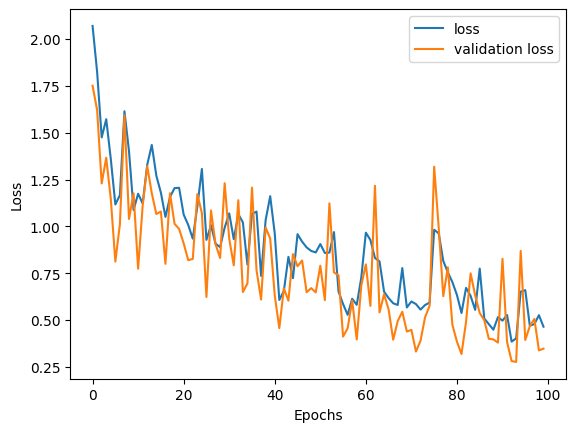

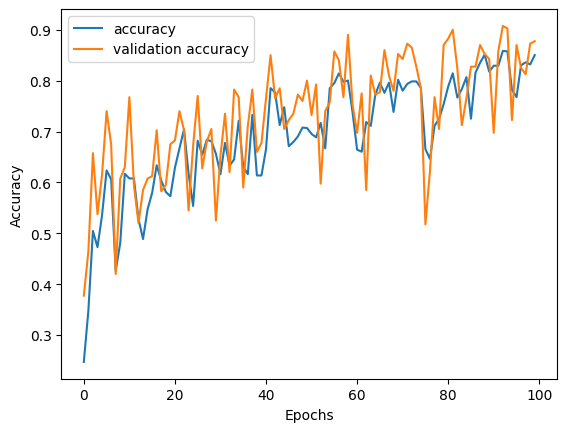

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

Tx = 30
n_classes = 10
n_features = 84

# Define the input layer
inputs = Input(shape=(Tx, n_features))

# First Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu'))(inputs)
x = layers.LayerNormalization()(x)  # Layer normalization

# Second Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu'))(x)
x = layers.LayerNormalization()(x)  # Layer normalization

# Third Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, activation='relu'))(x)
x = layers.LayerNormalization()(x)  # Layer normalization

# Fully connected layers
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)  # Dropout para evitar overfitting
x = layers.Dense(32, activation='relu')(x)

# Output layer
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot,
                    epochs=100,
                    batch_size=4,
                    validation_data=(X_dev, y_dev_onehot))

# Plot loss during training
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy during training
plt.plot(history.history['categorical_accuracy'], label='accuracy') 
plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
print('***'*50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Acuraccy on test data: {test_acc:.2f}')
print(f'Loss on training data: {test_loss:.2f}')

******************************************************************************************************************************************************
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - categorical_accuracy: 0.8633 - loss: 0.3866
Acuraccy on test data: 0.87
Loss on training data: 0.38


In [135]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import numpy as np

# Evaluar el modelo
print('***' * 50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Accuracy on test data: {test_acc:.2f}')
print(f'Loss on test data: {test_loss:.2f}')

# Obtener predicciones
y_pred_probs = model.predict(X_test)  # Probabilidades
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir a etiquetas
y_true = np.argmax(y_test_onehot, axis=1)  # Convertir one-hot a etiquetas

# Calcular recall, precisión, F1 y TNR (Tasa de Verdaderos Negativos)
recall = recall_score(y_true, y_pred, average=None)  # Recall por clase
precision = precision_score(y_true, y_pred, average=None)  # Precisión por clase
f1 = f1_score(y_true, y_pred, average=None)  # F1 por clase
conf_matrix = confusion_matrix(y_true, y_pred)  # Matriz de confusión

# Calcular TNR por clase (TNR = TN / (TN + FP))
tnr = []
for i in range(len(np.unique(y_true))):
    tn = conf_matrix[i, i]  # Verdaderos negativos
    fp = np.sum(conf_matrix[:, i]) - tn  # Falsos positivos
    tnr.append(tn / (tn + fp))

# Imprimir los resultados por clase
for i, label in enumerate(label_encoder.classes_):  # Asumiendo que tienes el `label_encoder`
    print(f'Class {label}:')
    print(f'  Recall: {recall[i]:.2f}')
    print(f'  Precision: {precision[i]:.2f}')
    print(f'  F1 Score: {f1[i]:.2f}')
    print(f'  TNR: {tnr[i]:.2f}')
    print('-' * 50)


******************************************************************************************************************************************************
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.8633 - loss: 0.3866
Accuracy on test data: 0.87
Loss on test data: 0.38
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class 23:
  Recall: 0.88
  Precision: 0.92
  F1 Score: 0.90
  TNR: 0.92
--------------------------------------------------
Class BUENO:
  Recall: 0.93
  Precision: 0.95
  F1 Score: 0.94
  TNR: 0.95
--------------------------------------------------
Class HOLA:
  Recall: 0.97
  Precision: 0.69
  F1 Score: 0.81
  TNR: 0.69
--------------------------------------------------
Class MAL:
  Recall: 0.95
  Precision: 1.00
  F1 Score: 0.97
  TNR: 1.00
--------------------------------------------------
Class NO:
  Recall: 0.75
  Precision: 0.69
  F1 Score: 0.72
  TNR: 0.69
--------------------------------------------------
Class NOMBRE:
  Recall: 0.74
  Precision: 0.97
  F

In [96]:
c_acuracy = history.history['categorical_accuracy'][0::6]
v_acuracy = history.history['val_categorical_accuracy'][0::6]

epocas = np.linspace(0, len(history.history['categorical_accuracy']), 17,dtype=int)
epocas

array([  0,   6,  12,  18,  25,  31,  37,  43,  50,  56,  62,  68,  75,
        81,  87,  93, 100])

In [95]:
len(list(range(1,100+1))[0::6]), list(range(1,100+1))[0::6]

(17, [1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 73, 79, 85, 91, 97])

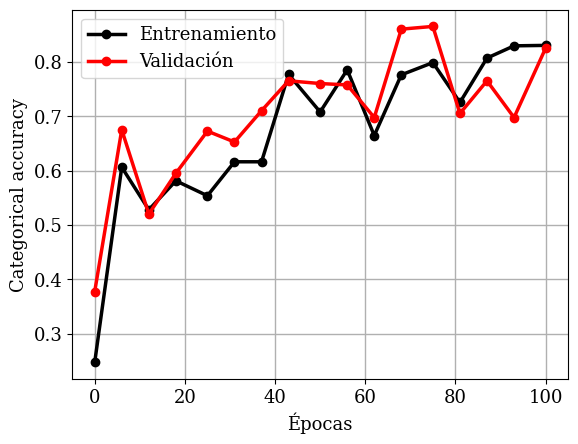

In [104]:

plt.rcParams.update({'font.size': 13, 'font.family': 'serif', 'font.sans-serif': 'Times New Roman'})

plt.plot(epocas, c_acuracy, label='Entrenamiento', color='black', linewidth=2.5, linestyle='-', marker='o')
plt.plot(epocas, v_acuracy, label='Validación', color='red', linewidth=2.5, linestyle='-', marker='o')

# Añadir leyenda y cuadrícula
plt.legend()
plt.grid(linewidth=1)

# Etiquetas y título con la fuente configurada
plt.xlabel('Épocas')
plt.ylabel('Categorical accuracy')

# Guardar la figura
plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\lstm_history.pdf')

# Mostrar el gráfico
plt.show()


### Confusion matrix

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


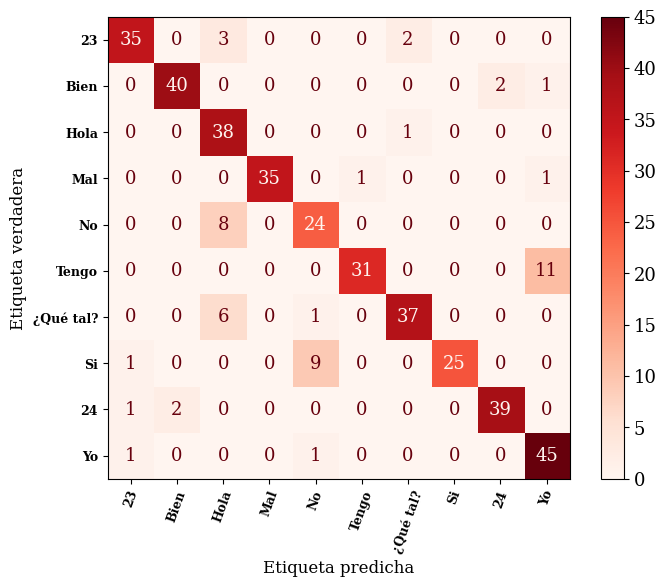

Categorical Accuracy: 0.8703
Accuracy per class: [0.875      0.93023256 0.97435897 0.94594595 0.75       0.73809524
 0.84090909 0.71428571 0.92857143 0.95744681]


In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.family': 'serif', 'font.sans-serif': 'Times New Roman'})
# Predicciones del modelo
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Predicciones
valores = np.array(['23', 'Bien', 'Hola', 'Mal', 'No','Tengo', '¿Qué tal?', 'Si', '24', 'Yo' ])
# Verdaderos valores
y_true_class = np.argmax(y_test_onehot, axis=1)  # Valores reales

# Matriz de confusión
cm = confusion_matrix(y_true_class, y_pred)

# Crear el display de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valores)

# Plot con ajustes
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Reds', xticks_rotation='vertical', ax=ax)

# Poner en negrita las etiquetas de los ejes X y Y
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=10)

# Ajustar la transparencia
for text in ax.texts:
    text.set_alpha(1)  # Ajustar la transparencia
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)  # Tamaño más pequeño para las etiquetas
plt.xlabel('Etiqueta predicha', fontsize=12)
plt.ylabel('Etiqueta verdadera', fontsize=12)

plt.xticks(rotation=70)
plt.savefig(r'C:\Users\hgera\Downloads\confusion_matrix_dimanics.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Sumar los valores diagonales (predicciones correctas)
correct_predictions = np.trace(cm)

# Sumar todos los valores de la matriz (total de predicciones)
total_predictions = np.sum(cm)

# Calcular la categorical accuracy
categorical_accuracy = correct_predictions / total_predictions

print(f'Categorical Accuracy: {categorical_accuracy:.4f}')
# Precisión por clase
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("Accuracy per class:", accuracy_per_class)


In [23]:
sdsd

NameError: name 'sdsd' is not defined

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Clase 0: Best treshold = 0.1420673429965973
Clase 1: Best treshold = 0.45159831643104553
Clase 2: Best treshold = 0.5979265570640564
Clase 3: Best treshold = 0.36826014518737793
Clase 4: Best treshold = 0.06966089457273483
Clase 5: Best treshold = 0.04046082869172096
Clase 6: Best treshold = 0.19663669168949127
Clase 7: Best treshold = 0.09555752575397491
Clase 8: Best treshold = 0.013931763358414173
Clase 9: Best treshold = 0.38746020197868347


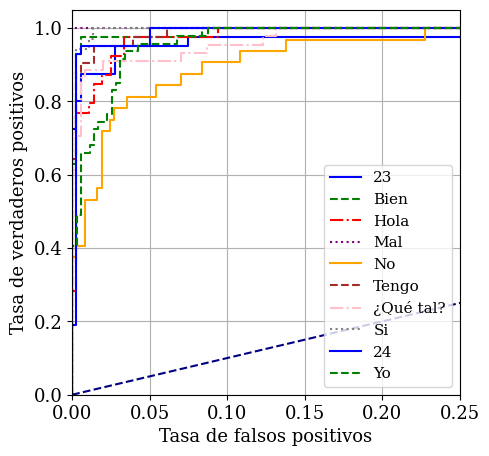

Optimized Tresholds per class  [0.14206734 0.45159832 0.59792656 0.36826015 0.06966089 0.04046083
 0.19663669 0.09555753 0.01393176 0.3874602 ]


In [134]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
# Estilos para las curvas
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']  # Estilos de línea
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']  # Colores de las curvas
y_pred = model.predict(X_test)
num_classes = y_train_onehot.shape[1]
best_thresholds = np.zeros(num_classes)

plt.figure(figsize=(5, 5))

#### Calculate ROC curve and ROC area for each class
for i in range(num_classes):
    y_true_binary = (y_true_class == i).astype(int)
    # print(y_true_binary)
    #### Compute ROC curve and ROC area
    fpr, tpr, threshold = roc_curve(y_true_binary, y_pred[:,i])
    #### Calcualte Youden's J statistic
    J = tpr - fpr
    best_threshold = threshold[np.argmax(J)]
    best_thresholds[i] = best_threshold
    
    print(f'Clase {i}: Best treshold = {best_threshold}')
    
    
    
    ### Calcular el área bajo la curva ROC
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{valores[i]}', linewidth=1.5, linestyle=line_styles[i % len(line_styles)], 
             color=colors[i % len(colors)])
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=1.5)
plt.xlim([0.0, 0.25])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.grid()
plt.ylabel('Tasa de verdaderos positivos')
# plt.title('Curva ROC')
plt.legend(loc="lower right", fontsize=11)
plt.savefig(r'C:\Users\hgera\Downloads\roc_curve_dimanics.pdf')

plt.show()



print('Optimized Tresholds per class ',best_thresholds)

In [ ]:
# * Save the model
path_save = '..\\..\\models\\Trained\\sign\\dynamic_model_all.h5'
model.save(path_save)

In [ ]:
model = tf.keras.models.load_model(path_save)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 84)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       218,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026,988 (3.92 MB)

 Trainable params: 1,026,986 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)